# Self-Driving Car Engineer Nanodegree

## Deep Learning Project: Build a Traffic Sign Recognition Classifier

## - Brian Erickson

This notebook implements the Udacity Self Driving Car course "Build a Traffic Sign Recognition Classifier" assignment.  It extends concepts presented in class and draws greatly on Lan YeCunn's LeNet archictecture given at http://yann.lecun.com/exdb/lenet/.

This demonstrates a traffic sign classifier that trained on and is able to classify German traffic signs.  The training and test data were provided.


### Imports and Helper Functions

The helper functions below will be used throughout the notebook.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import math
import time
import skimage.transform
import random
import os
%matplotlib inline

In [2]:
# to make "random" calls predictable, use a fixed seed
# since I'm using random from  numpy, tensorflow and from the 
# standard python random, I have a single seed helper
# that will take care of all
def seed(n=32568):
    """
    Seeds the random number generators
    """
    np.random.seed(n)
    random.seed(n)
    tf.set_random_seed(n)
    

In [3]:
def plot_counts(y, title):
    """
    Plots a histogram of label counts
    """
    fig = plt.figure()
    fig.set_size_inches(w=8,h=4)
    pd.value_counts(y).plot(kind="bar",title=title)
    pass

In [4]:
def plot_image(img,title=None):
    cmap = 'gray' if np.ndim(img) == 2 else None
    plt.axis('off')
    plt.imshow(img, cmap=cmap, interpolation='none')
    if title is not None:
        plt.title(title)

In [5]:
def plot_images(l, images_per_line = 10, image_size_inches = 1.0, title=None):
    """
    Plots images in a grid
    """
    fig=plt.figure()
    if title is not None:
        fig.suptitle(title)
    line_count=math.ceil(len(l)/images_per_line)
    fig.set_size_inches(w=images_per_line*image_size_inches,h=line_count*image_size_inches)
    for i in range(len(l)):
        img=l[i]
        plt.subplot(line_count,10,i+1)
        plot_image(img)

def random_from_lists(list1,list2,n=None):
    """
    Returns n random from parallel arrays list1 and list2 sampled without replacement
    
    If n is none, the entire lists will be randomized
    """    
    if n is None:
        n = len(list1)
    indexes = random.sample(range(len(list1)),n)
    out1 = []
    out2 = []
    for i  in indexes:
        out1.append(list1[i])
        out2.append(list2[i])
    return np.array(out1),np.array(out2)

In [6]:
def random_sample(x,n):
    """
    Returns n random samples out of array like variable x
    """
    if n > len(x): n = x
    indexes =np.random.choice(range(len(x)),n)
    r = []
    for i in indexes:
        r.append(x[i])
    return np.array(r)

In [7]:
def preprocess_image_bw(img, normalized=True):
    """
    Transforms a RGB input image into a grayscale images suitable for classifier input
    """
    g =  cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return g

In [8]:
def transform_matrix(m=None,cx=0.0,cy=0.0,theta=0.,scale=1.0,dx=0,dy=0):
    """
    Returns a 3x3 homogeneous transformation matrix.
    
    Parameters
    ----------
    theta : degrees to rotate ccw
    cx,cy : center for scaling and rotating
    dx,dy : translations
    scale : scaling ratio
    """
    
    if m is None:
        m = np.eye(3)
    
    # center offset
    c = np.array([[1,0,cx],[0,1,cy], [0,0,1]]) 
    ci = np.array([[1,0,-cx],[0,1,-cy], [0,0,1]]) 
    
    # translation
    t = np.array([[1,0,dx],[0,1,dy], [0,0,1]])
    
    # rotation
    r = np.array([[math.cos(theta),-math.sin(theta),0],[math.sin(theta),math.cos(theta),0],[0,0,1]])
    
    # scale
    s = np.array([[scale,0,0],[0,scale,0],[0,0,1]])
    
    v = np.dot(m,c)
    v = np.dot(v,r)
    v = np.dot(v,s)
    v = np.dot(v,ci)
    v = np.dot(v,t)
    return v

In [9]:
def transformed_image(img,theta=0.0,dx=0.0,dy=0.0,scale=1.0):
    """
    Returns an transformed copy of img
    """
    cx,cy = np.shape(img)
    cx = cx / 2
    cy = cy / 2
    t = transform_matrix(cx=cx,cy=cy,theta=theta,dy=dy,dx=dx,scale=scale)
    return skimage.transform.warp(img, inverse_map=np.linalg.inv(t),mode='reflect')


def augmented_image(img):
    """
    Returns a randomly transformed image
    """
    theta = random.choice([-15,-10,-5,0,5,10,15,20])
    dx = random.choice([-2,-1,0,1,2])
    dy = random.choice([-2,-1,0,1,2])
    scale = random.choice([.95,1.0,1.05])
    return transformed_image(img,theta * math.pi/180,dx,dy,scale)

In [10]:
def find(l,x):
    '''returns indexes of items in l with value x'''
    return [i for i, v in enumerate(l) if v==x]

In [11]:
def augment_images(x,y,minimum_count):
    """
    Returns an augmented dataset of (x',y') where each label has at least minimum_count entries
    """
    new_x = np.copy(x)
    new_y = np.copy(y)
    counts = np.bincount(y)
    labels = np.unique(y)
    minimum_count = 1000
    for i in range(len(labels)):
        label = labels[i]
        count = counts[i]
        print ("label: {} count: {}, ".format(label,count), end="")
        if count >= minimum_count:
            print("ok", end="")
        else:
            number_to_generate = minimum_count - count
            print("generating {} more".format(number_to_generate),end="")
            image_indexes = find(y_train,label)
            new_images = []
            new_labels = []
            for _ in range(number_to_generate):
                original = X_train_bw[random.choice(image_indexes)]
                new_images.append(augmented_image(original))
                new_labels.append(label)
            new_x = np.append(new_x,np.array(new_images),axis=0)
            new_y = np.append(new_y,np.array(new_labels,dtype=np.int64),axis=0)
        print()
    return new_x,new_y
            
          

---
## Step 0: Load The Data

In [12]:
# Load pickled data
import pickle
def import_data():
    global X_train,y_train,X_test,y_test

    # TODO: Fill this in based on where you saved the training and testing data
    data_folder = "../traffic-signs-data"
    training_file = "/".join([data_folder,"train.p"])
    testing_file = "/".join([data_folder,"test.p"])

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train, sizes_train, coords_train = train['features'], train['labels'], train['sizes'], train['coords']
    X_test, y_test = test['features'], test['labels']
    
import_data()

In [13]:
# load signames
sign_names = pd.read_csv("signnames.csv")

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

### Basic data structures shapes
Below we show the basic shape of data, we see we have about 40,000 training examples and about 12,000 test examples.

In [14]:
image_shape = np.shape(X_train[0])
n_classes = len(np.unique(y_train))

print("Number of training examples =", len(X_train))
print("Number of testing examples =", len(X_test))
print("Image data shape =", np.shape(X_train[0]))
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [15]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.


### Counts by Label
Below I show the counts of training and test examples by label.  It is clear that some classes are much more heavily represented than others.  This may indicate a need for data augmentation.

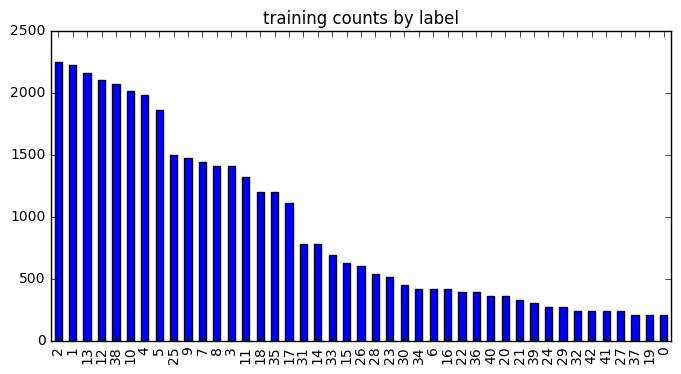

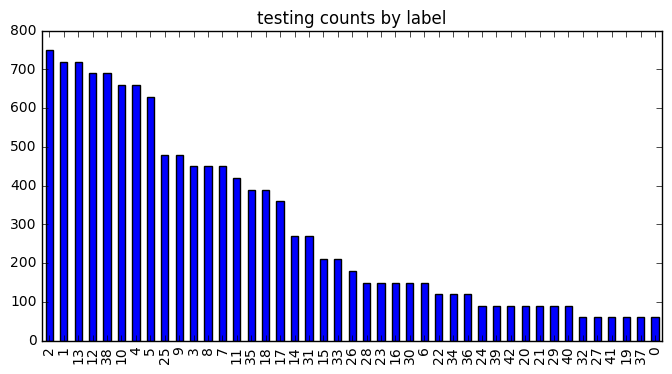

In [16]:
plot_counts(y_train, "training counts by label")
plot_counts(y_test, "testing counts by label")

### Input image visualization

If we look at the first few images, we notice that the are all very similar, likely they are sequential frames from a video sequence. Such similarity will cause problems as we train in batches and each batch contains very similar images.  

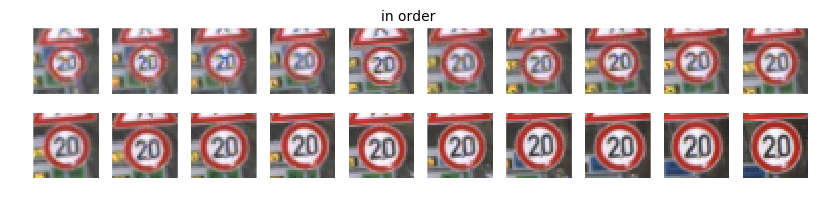

In [17]:
plot_images(X_train[0:20],title="in order")

If I take a random sample, I get something a little better for training input.  Below is a random sample of different images.  We notice that the images are at different brightness levels.  We will need to address this during pre-processing. Other things to notice are differences in sign size and legibility.  Some sign contents are almost illegible.

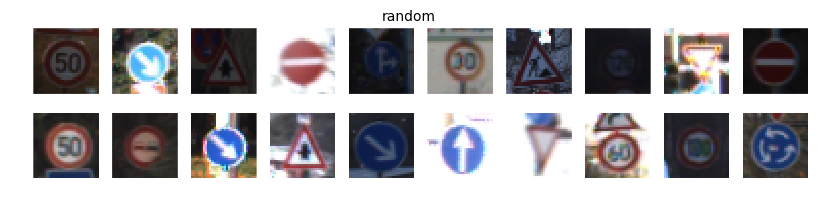

In [18]:
seed()
plot_images(random_sample(X_train,20),title="random")

## Preprocessing
I would like an image preprocessing operation that will

1. Take a color image as input
2. Set a greyscale image as output
3. Normalize the ouptut range so that very dark or bright images use the full greyscale range

Originally I was doing the image normalization myself, but it appears that the built in OpenCV function does the normalization. This doesn't appear to be documented.  It is clear in the images below that dark images are "brightened" in the preprocessing step and no additional normalization is required.

Here I convert the train and test imags to grayscale (bw)

In [19]:
X_train_bw = np.array([preprocess_image_bw(img) for img in X_train])
X_test_bw = np.array([preprocess_image_bw(img) for img in X_test])

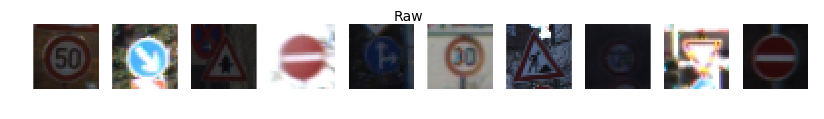

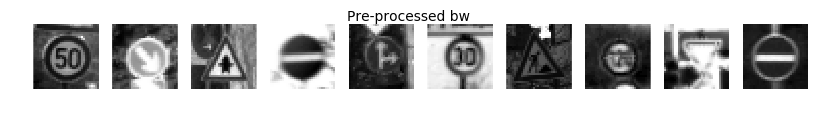

In [20]:
seed()

# visually show the pre-processing
o = random_sample(X_train,10)
plot_images(o,title='Raw')
plot_images([preprocess_image_bw(i) for i in o], title='Pre-processed bw')

As noted, some of the images categories with low counts could benefit from augmentation, here is an example of augmentation of a single image.

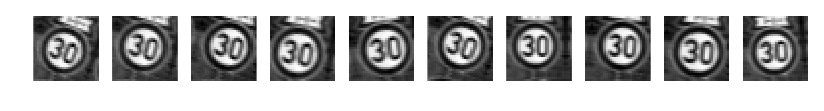

In [21]:
plot_images([augmented_image(X_train_bw[1000]) for i in range(10)])

Since the augmentation looks good, I augment the training data to make sure there are at least 1000 samples per label and plot a new histogram to make sure the counts are what I expected.

In [22]:
new_x,new_y = augment_images(X_train_bw, y_train, minimum_count = 1000)

label: 0 count: 210, generating 790 more
label: 1 count: 2220, ok
label: 2 count: 2250, ok
label: 3 count: 1410, ok
label: 4 count: 1980, ok
label: 5 count: 1860, ok
label: 6 count: 420, generating 580 more
label: 7 count: 1440, ok
label: 8 count: 1410, ok
label: 9 count: 1470, ok
label: 10 count: 2010, ok
label: 11 count: 1320, ok
label: 12 count: 2100, ok
label: 13 count: 2160, ok
label: 14 count: 780, generating 220 more
label: 15 count: 630, generating 370 more
label: 16 count: 420, generating 580 more
label: 17 count: 1110, ok
label: 18 count: 1200, ok
label: 19 count: 210, generating 790 more
label: 20 count: 360, generating 640 more
label: 21 count: 330, generating 670 more
label: 22 count: 390, generating 610 more
label: 23 count: 510, generating 490 more
label: 24 count: 270, generating 730 more
label: 25 count: 1500, ok
label: 26 count: 600, generating 400 more
label: 27 count: 240, generating 760 more
label: 28 count: 540, generating 460 more
label: 29 count: 270, generating

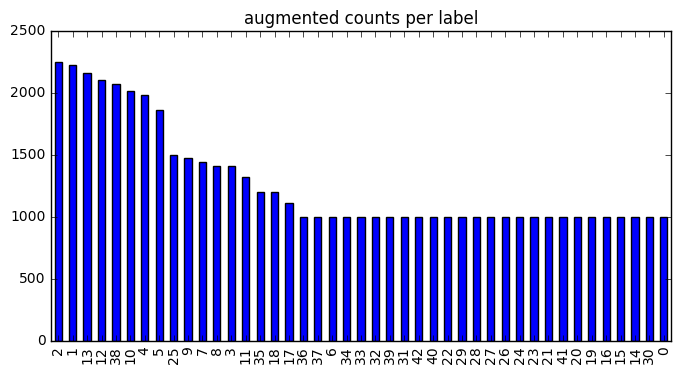

In [23]:
plot_counts(new_y, "augmented counts per label")


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [24]:
# returns test_x, test_y, valid_x and valid_y taken from test_x 
def split_test_and_validation(x, y, ratio_test=0.2):
    split_point = int(len(x)*ratio_test)
    return x[0:split_point], y[0:split_point], x[split_point:], y[split_point:]

Just to make sure that I don't overfit based on the test data, I reserve a 20% validation test set.

In [25]:
X_test_bw,y_test,X_valid_bw,y_valid = split_test_and_validation(X_test_bw, y_test, ratio_test=0.8)

In [26]:
from tensorflow.contrib.layers import flatten
def LeNet(x):
    # Reshape from 2D to 4D. This prepares the data for
    x = tf.reshape(x, (-1, 32, 32, 1))

    # Hyperparameters
    mu = 0.0
    sigma = 0.01

    # Convolution Layer 1. Input = 32x32x3. Output = 28x28x6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # Convolution Layer 2. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Flatten Layer.
    fc1 = flatten(conv2)
    fc1_shape = (fc1.get_shape().as_list()[-1], 120)

    # SOLUTION: Fully Connected Layer 1. Input = 5x5x16. Output = 120.
    fc1_W     = tf.Variable(tf.truncated_normal(shape=(fc1_shape), mean = mu, stddev = sigma))
    fc1_b     = tf.Variable(tf.zeros(120))
    fc1       = tf.matmul(fc1, fc1_W) + fc1_b
    fc1       = tf.nn.dropout(fc1,keep_prob=1.0-dropout_rate)

    # SOLUTION: Activation 3.
    fc1 = tf.nn.relu(fc1)

    # SOLUTION: Fully Connected Layer 2. Input = 120. Output = n_classes.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, n_classes), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc1, fc2_W) + fc2_b

    return logits

In [27]:
x = tf.placeholder(tf.float32, (None, 32, 32))
y = tf.placeholder(tf.int32, (None))
dropout_rate = tf.placeholder(tf.float32,(None))
one_hot_y = tf.one_hot(y, n_classes)

fc2 = LeNet(x)

In [28]:
softmax_op = tf.nn.sparse_softmax_cross_entropy_with_logits(fc2, y)
loss_op = tf.reduce_mean(softmax_op)
train_op = tf.train.AdamOptimizer().minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predict_op = tf.argmax(fc2, 1)

In [29]:
def eval_data(x_data_in,y_data_in,batch_size=256):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    # If dataset.num_examples is not divisible by BATCH_SIZE
    # the remainder will be discarded.
    # Ex: If BATCH_SIZE is 64 and training set has 55000 examples
    # steps_per_epoch = 55000 // 64 = 859
    # num_examples = 859 * 64 = 54976
    #
    # So in that case we go over 54976 examples instead of 55000.
    #steps_per_epoch = dataset.num_examples // BATCH_SIZE
    steps_per_epoch=np.size(y_data_in)//batch_size
    num_examples = steps_per_epoch * batch_size
    total_acc, total_loss = 0, 0
    sess = tf.get_default_session()
    for step in range(steps_per_epoch):
        n_start = step*batch_size        
        batch_x =  x_data_in[n_start:n_start+batch_size]
        batch_y =  y_data_in[n_start:n_start+batch_size]
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, dropout_rate:0.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples

In [30]:
class Object:
    pass

In [31]:
def train_network(x_data, y_data, x_validp, y_validp, sess, epochs=20, batch_size=32):
    sess.run(tf.global_variables_initializer())
    steps_per_epoch = len(y_data) // batch_size
    num_examples = steps_per_epoch * batch_size

    losses = []
    accuracies = []
    train_losses = []
    train_accuracies = []
    # Train model
    for i in range(epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        for step in range(steps_per_epoch):
            n_start = step*batch_size
            #print(n_start)
            batch_x = x_data[n_start:n_start+batch_size,:,:]
            batch_y = y_data[n_start:n_start+batch_size]
            _,loss,accuracy = sess.run([train_op,loss_op,accuracy_op], feed_dict={x: batch_x, y: batch_y, 
                                                                                  dropout_rate:0.5})
            train_loss += loss
            train_accuracy += accuracy
        train_loss /= steps_per_epoch
        train_accuracy /= steps_per_epoch
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_acc = eval_data(x_validp, y_validp, batch_size=512)
        losses.append(val_loss)
        accuracies.append(val_acc)
        print("EPOCH {} .".format(i+1), end="")
        print(" Training loss = {:.3f}".format(train_loss), end="")
        print(" Training accuracy = {:.3f}".format(accuracy), end="")
        print(" Validation loss = {:.3f}".format(val_loss), end="")
        print(" Validation accuracy = {:.3f}".format(val_acc))
        
    run = Object()
    run.test_losses = losses
    run.test_accuracies = accuracies
    run.train_losses = train_losses
    run.train_accuracies = train_accuracies
    return run

In [32]:
try:
    session.close()
except:
    pass
session = tf.InteractiveSession()

_x,_y=random_from_lists(new_x,new_y)
run = train_network(_x,_y,X_valid_bw,y_valid, sess=session, epochs=50, batch_size=512)

EPOCH 1 . Training loss = 2.526 Training accuracy = 0.539 Validation loss = 0.883 Validation accuracy = 0.819
EPOCH 2 . Training loss = 1.489 Training accuracy = 0.605 Validation loss = 0.631 Validation accuracy = 0.878
EPOCH 3 . Training loss = 1.232 Training accuracy = 0.672 Validation loss = 0.598 Validation accuracy = 0.897
EPOCH 4 . Training loss = 1.091 Training accuracy = 0.686 Validation loss = 0.586 Validation accuracy = 0.900
EPOCH 5 . Training loss = 0.968 Training accuracy = 0.719 Validation loss = 0.601 Validation accuracy = 0.911
EPOCH 6 . Training loss = 0.844 Training accuracy = 0.768 Validation loss = 0.546 Validation accuracy = 0.918
EPOCH 7 . Training loss = 0.762 Training accuracy = 0.766 Validation loss = 0.606 Validation accuracy = 0.913
EPOCH 8 . Training loss = 0.701 Training accuracy = 0.809 Validation loss = 0.608 Validation accuracy = 0.919
EPOCH 9 . Training loss = 0.648 Training accuracy = 0.787 Validation loss = 0.586 Validation accuracy = 0.917
EPOCH 10 .

Max validation accuracy 0.943
Final validation accuracy 0.943


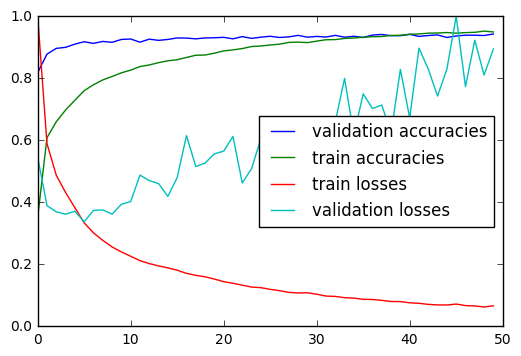

In [33]:
plt.plot(run.test_accuracies,label='validation accuracies')
plt.plot(run.train_accuracies,label='train accuracies')
plt.plot(run.train_losses/np.max(run.train_losses),label='train losses')
plt.plot(run.test_losses/np.max(run.test_losses),label='validation losses')
plt.legend(loc='best')
print("Max validation accuracy {:.3f}".format(max(run.test_accuracies)))
print("Final validation accuracy {:.3f}".format(run.test_accuracies[-1]))


In [34]:
t_loss,t_accuracy  = eval_data(X_test_bw,y_test)
print("Test loss: {:.2f}, Test accuracy: {:.3f}".format(t_loss,t_accuracy))

Test loss: 1.06, Test accuracy: 0.953


Below are some random examples of prediction failures.  

In [35]:
def predict_one(img):
    if np.shape(img)!=(32,32): 
        raise("images must be 32,32 grayscale")
    a=np.reshape(img,[1,32,32])
    return predict_op.eval(feed_dict={x: [img], dropout_rate:0.0})[0]

predict_one(X_test_bw[0])


16

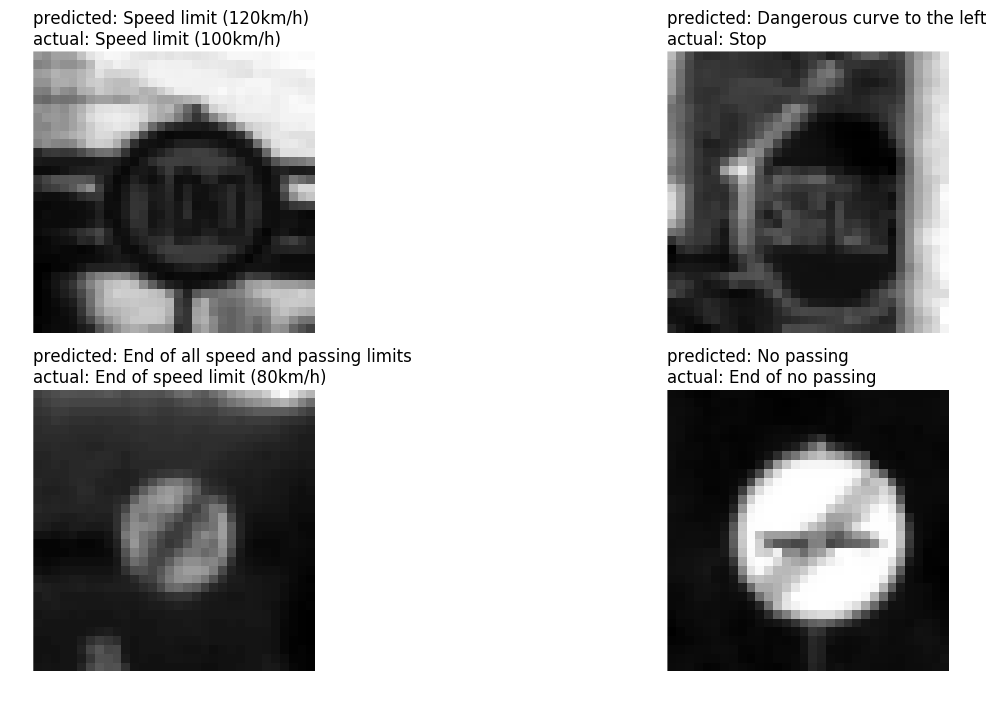

In [36]:
seed()

sample_x,sample_y = random_from_lists(X_test_bw,y_test,100)
correct=[]
incorrect=[]
p = 0
plt.figure(figsize=(15,8))
for i in range(len(sample_x)):
    predicted = predict_one(sample_x[i])
    actual=sample_y[i]
    if(predicted==actual):
        correct.append(sample_y[i])
        #plt.title("ok: {}".format(sign_names.SignName[predicted]))
    else:
        p+=1
        if p>4: break
        incorrect.append(sample_y[i])
        plt.subplot(2,2,p)
        plot_image(sample_x[i])
        title_text = "predicted: {}\nactual: {}".format(sign_names.SignName[predicted],sign_names.SignName[actual])
        plt.title(title_text, loc='left')
        #plt.title("\n".join(wrap(title_text, 60)))
    
    

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

To keep the processing simple, I chose to represent the images using grayscale. This provided me with a one dimensional input space to my CNN.  I did notice that there were different brighntess levels for the input images and used a grayscale conversion function that normalized the images brightness.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The training and testing data were already separated in the input data.  I used these. Since there seemed to be enough test data to allow for a separate test and validation set, I used 80% of the test data for a validation set and 20% for a test set.

Since the original training dataset had a small number of examples for certain labels, I decided to augment the data with distorted vesions of the training images. I introduced enough augmented training examples to ensure that there were at least 1000 examples per label. I used rotations and translations picked randomly as shown below:


    theta = random.choice([-15,-10,-5,0,5,10,15,20])
    dx = random.choice([-2,-1,0,1,2])
    dy = random.choice([-2,-1,0,1,2])
    scale = random.choice([.95,1.0,1.05])

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I started with the code from the classroom tutorial on Mnist for a simplified LeNet. This code has two convolutional layers and a fully connected layer.  The model presented in the tutorial used max pooling at two different points to keep from overfitting.  Activations are done with the Relu function.

From the lectures, I learned that max pooling wasn't the preferred method these days for preventing over-fitting and that dropout might work better.

I changed the network by removing the max pooling steps and added a dropout at the final fully connected layer.  The dropout gives the additional benefit of the network being able to look at the features at full resolution at the fully connected layer.

The final architecture looks like this

    input(32x32) -> conv1(5x5x6) -> conv2(5,5.17) -> fully_connected -> softmax/onehot

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I batched my input and then ran across several inputs.  At first, training wasn't going so well.  I determined that batching on input data with sorted labels was causing the model to do very poorly.  I am guessing this is because with a stream of identical labels, the model ended up "forgetting" the previous labels.  I fixed this problem by randomizing the order of my input data in a pre-processing step.

After that, I played with different values of sigma for my weights.  Lower values of sigma seemed to do better, so I kept the sigma of 0.01.

I then played with different batch sizes.  Larger batch sizes would converge slower but each epoch would run faster.  Smaller batch sizes would converge more quickly, but would end up with a lower accuracy.  I settled on using a batch size of 512.  This batch size performed well and was fairly well trained after the first 10 epochs and optimized after about 50 epochs.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I tried different batch sizes.  Larger batch sizes were faster, but smaller batches, on the order of 32 seemed to work better.

I manually looked at the images before trying any training.  I did normalization of the image to make it look better to my eye.

I was getting about 77% accuracy with the LeNet starter code.  I added a dropout term, and noticed that while training took longer, accuracy jumped to about 88%.  That was a huge improvement.

I augmented the image data to enrich for labels with lower numbers of examples.

It was largely trial and error with the tuning parameters, but I settled on the batch size of 512, sigma of 0.01.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

First, I found images from the internet by searching for "traffic signs".  I chose the first few.  None of them look like the samples from the German traffic signs dataset, so I don't really expect them to be classified very well.

I resized and preprocessed the images to come up with 32x32 grayscale images as shown below.

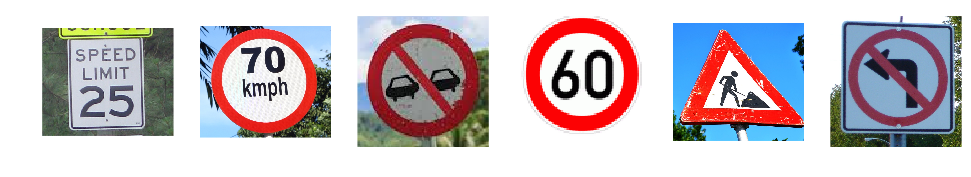

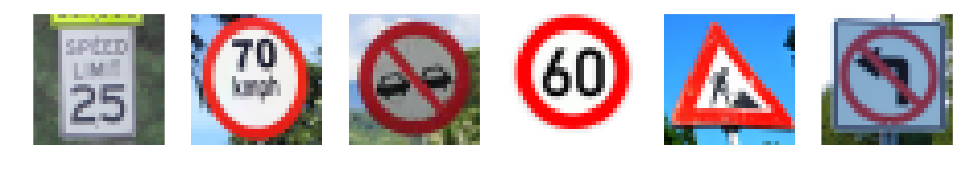

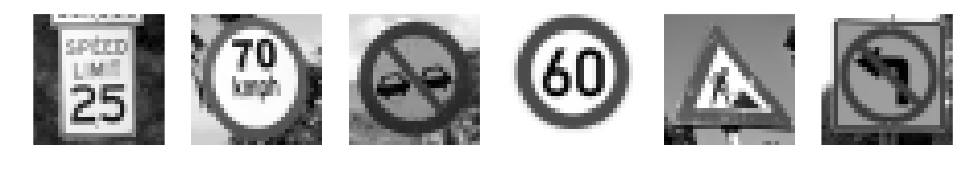

In [37]:
path="extra_input"
raw_images = [plt.imread(path+"/"+f) for f in os.listdir(path)]
plot_images(raw_images,image_size_inches=2)
small_images = [cv2.resize(im,(32,32),interpolation=cv2.INTER_AREA) for im in raw_images]
plot_images(small_images,image_size_inches=2)
bw_images = [preprocess_image_bw(im) for im in small_images]
plot_images(bw_images,image_size_inches=2)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Below, I run the classifier against the images, the results are actually terrible.  I expected the "60" sign to be recognized because it is more or less perfect and matches the style of the training dataset, but it still wasn't recognized correctly.  If I try, I can maybe see why the incorrect choices were made, for example the "Roundabout mandatory" sign contains a circle which could have been mistaken for the circle in the roundabout sign.  But, I would say that the network does a really bad job generalizing to new sign types.

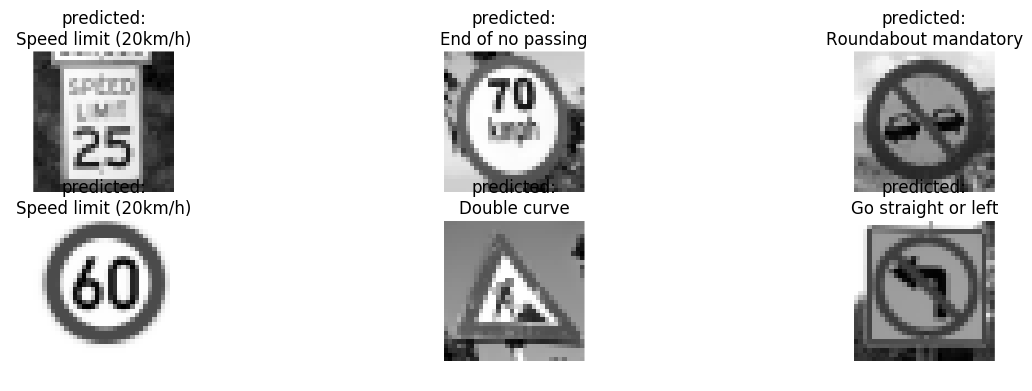

In [38]:
i = 0
plt.figure(figsize=(15,4))
for im in bw_images:
    i+=1
    predicted_name = sign_names.SignName[predict_one(im)]
    plt.subplot(2,3,i)
    plot_image(im, title= "predicted:\n{}".format(predicted_name))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:**

To investigate if the model gets the answer right on the 2nd or 3rd guess, I retrieve the top five highest voted labels of each test image.

In [39]:
def get_top_k(images, k=3):
    ''' returns (certainties, labels) of predictions for supplied images '''
    feed_dict = {x:images, dropout_rate:0.5}
    s = fc2.eval(feed_dict = feed_dict)
    a,b = tf.nn.top_k(s,k=k)
    return a.eval(),b.eval()
    return tf.nn.top_k(s,k=3)

In [40]:
certainties, labels = get_top_k(X_test_bw,k=5)


I then compare those with the correct ranging to see how many times the correct image was the top ranked value in the softmax, how many times it was 2nd, 3rd, 4th, and 5th place.  

In [41]:
matches_by_rank = {}
for i in range(np.shape(labels)[1]):
    matches_by_rank[i+1] = np.sum(labels[:,i]==y_test)

matches_by_rank['other'] = len(y_test) - np.sum(list(matches_by_rank.values()))
    
print(matches_by_rank)

    

{1: 9336, 2: 321, 3: 120, 4: 73, 5: 49, 'other': 205}


We see that most of the time if the image wasn't guessed correctly in the top ranked position, it is usually predicted correctly in the models 2nd or 3rd guess. The second or third ranked prediction is correct more often than the prediction not being in the top 5.  Below is a bar chart showing the same data graphically.

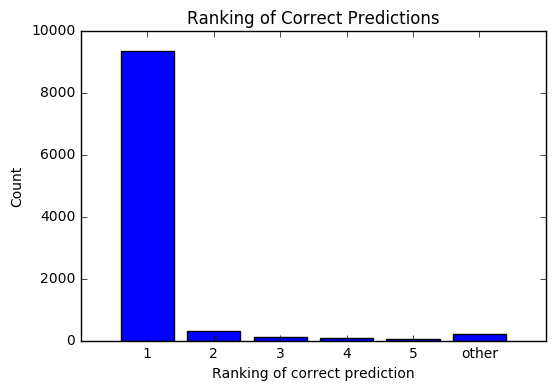

In [42]:
xticks = range(6)
ax = plt.bar(xticks, list(matches_by_rank.values()), align='center')
plt.title("Ranking of Correct Predictions")
plt.ylabel("Count")
plt.xlabel("Ranking of correct prediction")
plt.xticks(xticks, list(matches_by_rank.keys()))
pass

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

Lastly, I look at the certainties of the predictions.  I'm not sure I really understand the output since I would expect values roughly between zero and one, and instead I am getting values. If I am interpreting this correctly, the model seems over-certain of its predictions.

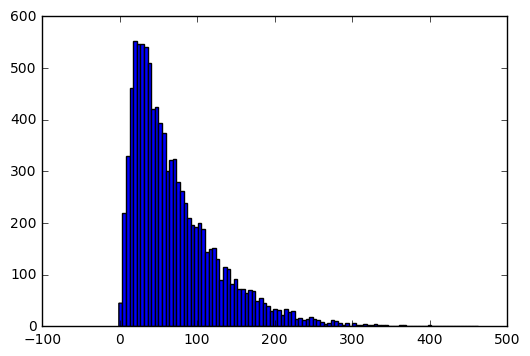

In [43]:
_ = plt.hist(certainties[:,0],bins=100)

# Appendix

## Investigation into color pre-processing
Below are some investgations I made into pre-processing into better color images.  Since for now, I decided to stay with grayscale, I moved the color prepossing code to the appendix.  This may later be useful in multi-channel input is desired.

In [44]:
def preprocess_image(img, dst=None, use_yuv=False):
    if dst is None:
        dst = np.zeros_like(img)
    if use_yuv:
        yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        y,u,v=cv2.split(yuv)
        #cv2.equalizeHist(y,y)
        y=(y-y.min())*(255./(y.max()-y.min()))
        y=y.astype(np.uint8)
        yuv=cv2.merge((y,u,v))
        dst = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    else:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h,s,v=cv2.split(hsv)
        v=(v-v.min())*(255./(v.max()-v.min()))
        v=v.astype(np.uint8)
        hsv=cv2.merge((h,s,v))
        dst = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return dst
    

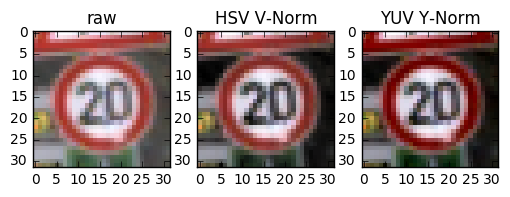

In [45]:
#demonstration of preprocessing an image
img = X_train[12]
plt.subplot(1,3,1)
plt.imshow(img,interpolation='none')
plt.title("raw")
plt.subplot(1,3,2)
plt.title("HSV V-Norm")
plt.imshow(preprocess_image(img),interpolation='none')
plt.subplot(1,3,3)
plt.title("YUV Y-Norm")
plt.imshow(preprocess_image(img, use_yuv=True),interpolation='none')
pass

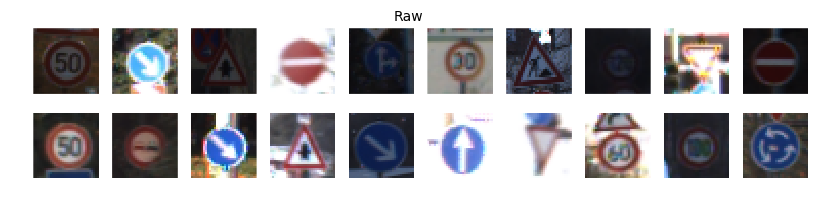

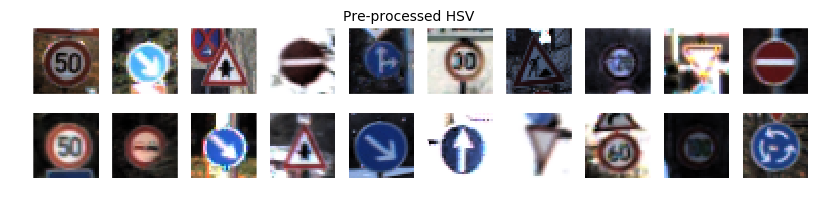

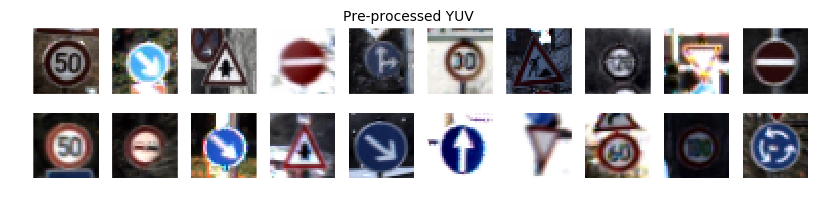

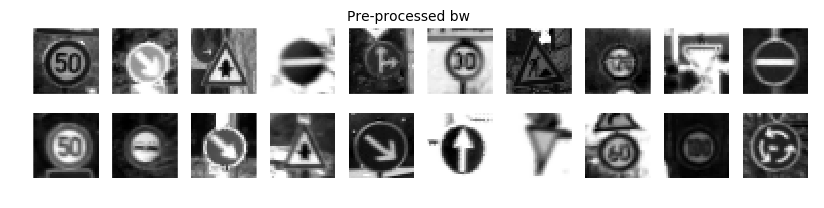

In [46]:
# visually show the different options of pre-processing
o = random_sample(X_train,20)
plot_images(o,title='Raw')
plot_images([preprocess_image(i) for i in o], title='Pre-processed HSV')
plot_images([preprocess_image(i,use_yuv=True) for i in o], title='Pre-processed YUV')
plot_images([preprocess_image_bw(i) for i in o], title='Pre-processed bw')